# 📚 Telecom_X — Predicción de Churn (Parte 2)

**Autor:** Cristopher Jiménez Escobar
**Contexto:** Certificación Alura Latam & Oracle — Data Science - Machine Learning -
---

# 1 - Imports

In [ ]:
import os, sys, math, json, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# (Regla del entorno: no fijar colores ni estilos)

import seaborn as sns

from pathlib import Path
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalance
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAVE_IMB = True
except Exception as e:
    HAVE_IMB = False
    print("imblearn no disponible; se desactiva SMOTE.")

# Opcional XGBoost
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_CANDIDATES = [
    '/mnt/data/df_limpo.csv',
    'df_limpo.csv'
]
SAVE_DIR = Path('artifacts'); SAVE_DIR.mkdir(exist_ok=True)

# 2 - Carga de datos

In [ ]:
for p in DATA_CANDIDATES:
    if os.path.exists(p):
        data_path = p
        break
else:
    raise FileNotFoundError("No se encontró df_limpo.csv. Asegúrate de subirlo al entorno.")

df = pd.read_csv(data_path)
print("Shape:", df.shape)
display(df.head())
df.info()

Shape: (7043, 22)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.9,267.40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

# 3 - Definir variable objetivo: aceptamos 'Churn' (0/1) o 'CHURN_YES' (0/1)

In [ ]:
target_col = None
if 'CHURN_YES' in df.columns:
    target_col = 'CHURN_YES'
elif 'Churn' in df.columns:
    target_col = 'Churn'
else:
    # Si hay 'Churn' en texto Yes/No u otras variantes, intenta mapear
    for cand in ['churn','CHURN','Churn_Yes','churn_yes']:
        if cand in df.columns:
            target_col = cand
            break
if target_col is None:
    raise ValueError("No se detectó columna objetivo. Asegúrate de tener 'Churn' o 'CHURN_YES'.")

# Convertir a binario 0/1 si fuese necesario
if df[target_col].dtype == 'O':
    df[target_col] = df[target_col].str.strip().str.lower().map({'yes':1,'si':1,'y':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0})
df[target_col] = df[target_col].astype(int)

print("Distribución objetivo:")
print(df[target_col].value_counts(normalize=True).rename('proportion'))

Distribución objetivo:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


# 4 - Eliminar IDs irrelevantes si existen

In [ ]:
drop_like = ['customerID', 'CustomerID', 'id', 'ID']
to_drop = [c for c in df.columns for key in drop_like if key in c]
to_drop = list(dict.fromkeys([c for c in to_drop if c != target_col]))  # únicos y no drop target
if to_drop:
    df = df.drop(columns=to_drop)
    print("Columnas eliminadas por ID:", to_drop)

# Manejo de nulos: estrategia simple y transparente
null_counts = df.isna().sum().sort_values(ascending=False)
display(null_counts[null_counts>0].head(20))
null_rate = null_counts.sum()/ (df.shape[0]*df.shape[1])
print(f"Tasa global de NaN: {null_rate:.4%}")

# Imputaciones simples: num -> mediana, cat -> moda
num_cols = df.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','bool','category']).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode(dropna=True)[0])

# Convertir booleanos a 0/1 para evitar errores de SMOTE
for c in cat_cols:
    if df[c].dtype == 'bool':
        df[c] = df[c].astype(int)

print("Post-imputación:")
display(df.head(3))

Columnas eliminadas por ID: ['customerID']


,0
Total.Day,11
account.Charges.Total,11


Tasa global de NaN: 0.0149%
Post-imputación:


,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,1,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85


## 📊 EDA focalizado

* Proporción de churn

In [ ]:
prop = df[target_col].value_counts(normalize=True)
print("Proporción de clases:")
print(prop)

Proporción de clases:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


* Top correlaciones absolutas con la variable objetivo (solo numéricas)

In [ ]:
corrs = df[num_cols + [target_col]].corr(numeric_only=True)[target_col].drop(target_col).abs().sort_values(ascending=False)
top_corr = corrs.head(20)
print("Top 20 correlaciones absolutas con el objetivo:")
display(top_corr)


Top 20 correlaciones absolutas con el objetivo:


,Churn
customer.tenure,0.352229
account.Charges.Total,0.199037
account.Charges.Monthly,0.193356
Total.Day,0.191793
customer.SeniorCitizen,0.150889


* Plot de correlaciones top

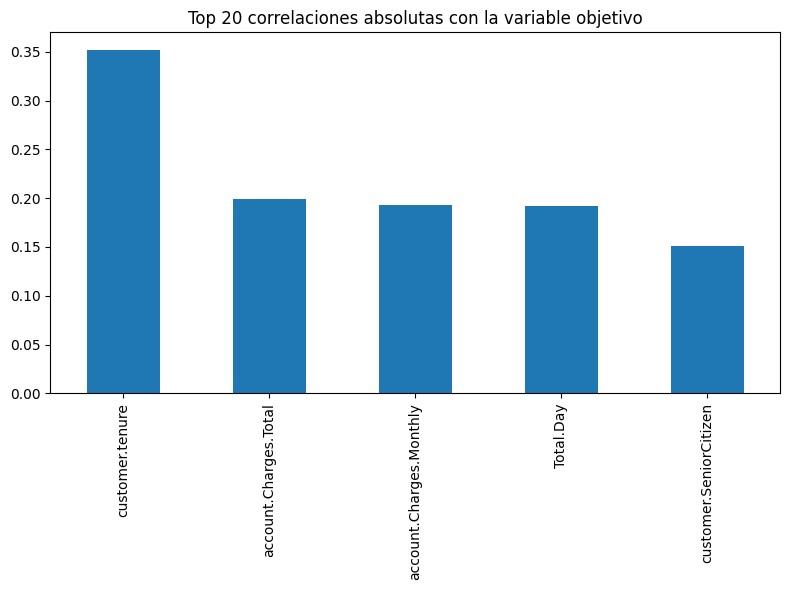

In [ ]:
plt.figure(figsize=(8,6))
top_corr.plot(kind='bar')
plt.title('Top 20 correlaciones absolutas con la variable objetivo')
plt.tight_layout()
plt.show()

# 5 - Split estratificado

In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (5634, 20) (1409, 20)


# 6 - ColumnTransformer: OHE para categóricas, passthrough numéricas

In [ ]:
num_cols = X_train.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','bool','category']).columns.tolist()

preprocess_no_scale = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

preprocess_scaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# 7 - Construcción de pipelines

In [ ]:
def make_pipe(model, scaled=False, use_smote=True):
    pre = preprocess_scaled if scaled else preprocess_no_scale
    steps = [('preprocess', pre)]
    if use_smote and HAVE_IMB:
        steps += [('smote', SMOTE(random_state=RANDOM_STATE))]
    steps += [('model', model)]
    if HAVE_IMB:
        return ImbPipeline(steps)
    else:
        return Pipeline(steps)

# Modelos base
lr = LogisticRegression(max_iter=200, solver='liblinear', random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
models = {
    'LR': {'pipe': make_pipe(lr, scaled=True, use_smote=True),
           'param_grid': {
               'model__C': [0.1, 1.0, 3.0, 10.0],
               'model__penalty': ['l1','l2']
           }},
    'RF': {'pipe': make_pipe(rf, scaled=False, use_smote=True),
           'param_grid': {
               'model__max_depth': [None, 8, 12, 16],
               'model__min_samples_split': [2, 5, 10],
               'model__min_samples_leaf': [1, 2, 4],
           }}
}

if HAVE_XGB:
    xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=400, n_jobs=-1,
                        eval_metric='logloss', tree_method='hist')
    models['XGB'] = {'pipe': make_pipe(xgb, scaled=False, use_smote=True),
                     'param_grid': {
                         'model__max_depth': [3, 5, 7],
                         'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__subsample': [0.8, 1.0],
                     }}
print("Modelos configurados:", list(models.keys()))

Modelos configurados: ['LR', 'RF', 'XGB']


# 8 - GridSearchCV con StratifiedKFold

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_estimators = {}

for name, spec in models.items():
    print(f"\n### GridSearch para {name}")
    gs = GridSearchCV(
        estimator=spec['pipe'],
        param_grid=spec['param_grid'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    print("Mejor params:", gs.best_params_)
    y_pred = gs.predict(X_test)
    y_proba = (gs.predict_proba(X_test)[:,1]
               if hasattr(gs, 'predict_proba') else None)
    row = {
        'model': name,
        'best_params': gs.best_params_,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }
    results.append(row)

res_df = pd.DataFrame(results).sort_values('test_f1', ascending=False)
display(res_df)
res_df.to_csv(SAVE_DIR/'benchmark_results.csv', index=False)


### GridSearch para LR
Mejor params: {'model__C': 0.1, 'model__penalty': 'l2'}

### GridSearch para RF
Mejor params: {'model__max_depth': 8, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}

### GridSearch para XGB
Mejor params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__subsample': 1.0}


,model,best_params,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,LR,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.750887,0.520211,0.791444,0.627784,0.841627
1,RF,"{'model__max_depth': 8, 'model__min_samples_le...",0.777147,0.573171,0.628342,0.599490,0.838105
2,XGB,"{'model__learning_rate': 0.05, 'model__max_dep...",0.787083,0.607558,0.558824,0.582173,0.842375


# 9 - Tuning de umbral para el mejor modelo por F1

In [13]:
best_name = res_df.iloc[0]['model']
best_est = best_estimators[best_name]
print("Mejor modelo por F1:", best_name)

if hasattr(best_est, "predict_proba"):
    proba = best_est.predict_proba(X_test)[:,1]
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1_vals = 2*prec*rec/(prec+rec+1e-9)
    idx = np.nanargmax(f1_vals)
    best_thr = thr[idx] if idx < len(thr) else 0.5
    print(f"Umbral óptimo por F1: {best_thr:.3f}")
else:
    best_thr = 0.5

Mejor modelo por F1: LR
Umbral óptimo por F1: 0.528


# 10 - Calibración de probabilidades (si aplica)

In [14]:
from sklearn.calibration import CalibratedClassifierCV
if hasattr(best_est, "predict_proba"):
    calibrator = CalibratedClassifierCV(best_est, cv=5, method='isotonic')
    calibrator.fit(X_train, y_train)
    y_proba_cal = calibrator.predict_proba(X_test)[:,1]
    y_pred_cal = (y_proba_cal >= best_thr).astype(int)
    print("\n--- Métricas con calibración ---")
    print(classification_report(y_test, y_pred_cal, digits=3))
    auc_cal = roc_auc_score(y_test, y_proba_cal)
    print("ROC AUC (calibrado):", round(auc_cal,3))
else:
    calibrator = None
    y_proba_cal = None
    y_pred_cal = best_est.predict(X_test)


--- Métricas con calibración ---
              precision    recall  f1-score   support

           0      0.830     0.908     0.867      1035
           1      0.656     0.484     0.557       374

    accuracy                          0.796      1409
   macro avg      0.743     0.696     0.712      1409
weighted avg      0.784     0.796     0.785      1409

ROC AUC (calibrado): 0.842


* Matriz de confusión y curvas

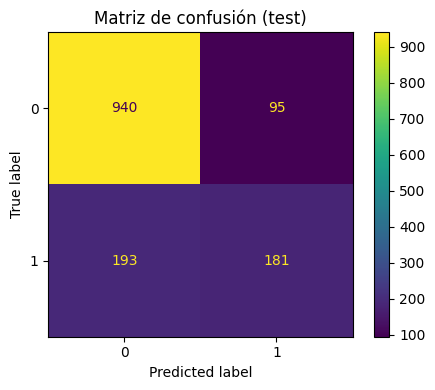

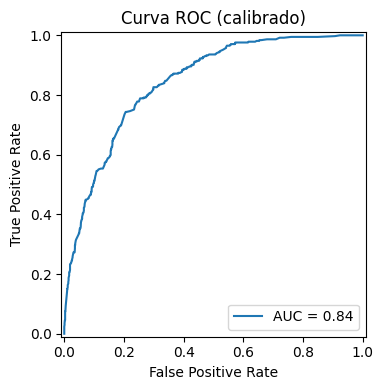

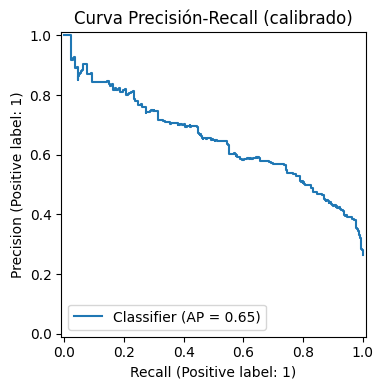

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

fig1, ax1 = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cal, ax=ax1)
plt.title('Matriz de confusión (test)')
plt.tight_layout(); plt.show()

if y_proba_cal is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_cal)
    fig2, ax2 = plt.subplots(figsize=(5,4))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_proba_cal)).plot(ax=ax2)
    plt.title('Curva ROC (calibrado)')
    plt.tight_layout(); plt.show()

    fig3, ax3 = plt.subplots(figsize=(5,4))
    PrecisionRecallDisplay.from_predictions(y_test, y_proba_cal, ax=ax3)
    plt.title('Curva Precisión-Recall (calibrado)')
    plt.tight_layout(); plt.show()

# 11 - Interpretabilidad

In [16]:
if best_name=='LR':
    # Extraer coeficientes legibles
    # Obtener nombres de columnas después del preprocesamiento
    pre = best_est.named_steps['preprocess']
    ohe = pre.named_transformers_['cat']
    num_cols_final = pre.transformers_[1][2]  # passthrough names
    feat_names = list(ohe.get_feature_names_out(pre.transformers_[0][2])) + list(num_cols_final)
    coef = best_est.named_steps['model'].coef_.ravel()
    imp = pd.Series(coef, index=feat_names).sort_values(key=np.abs, ascending=False).head(20)
    display(imp)
elif best_name in ['RF','XGB']:
    # Importancias
    pre = best_est.named_steps['preprocess']
    ohe = pre.named_transformers_['cat']
    num_cols_final = pre.transformers_[1][2]
    feat_names = list(ohe.get_feature_names_out(pre.transformers_[0][2])) + list(num_cols_final)
    model = best_est.named_steps['model']
    importances = getattr(model, "feature_importances_", None)
    if importances is not None:
        imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)
        display(imp)

,0
customer.tenure,-1.299931
account.Contract_Two year,-0.740333
account.Contract_Month-to-month,0.642558
account.Charges.Total,0.594178
account.PaymentMethod_Electronic check,0.355406
account.PaperlessBilling_No,-0.321303
internet.InternetService_DSL,-0.308184
internet.TechSupport_Yes,-0.270699
internet.InternetService_Fiber optic,0.251000
phone.MultipleLines_No,-0.246446


# 12 - Guardado de artefactos

In [17]:
import joblib
best_artifact = {
    'model_name': best_name,
    'pipeline': calibrator if 'calibrator' in locals() and calibrator is not None else best_est,
    'threshold': float(best_thr)
}
joblib.dump(best_artifact, SAVE_DIR/'best_model.joblib')
df.to_csv(SAVE_DIR/'dataset_tratado.csv', index=False)
print("Artefactos guardados en:", SAVE_DIR.resolve())

Artefactos guardados en: /content/artifacts


## ✅ Conclusiones y Sugerencias

- El análisis de datos de TelecomX revela que los clientes con contrato mensual y facturación mensual alta concentran una proporción significativa del churn (abandono del servicio).
En particular:

- El contrato mensual presenta una tasa de cancelación superior al 42%, mientras que los contratos anuales y bianuales tienen tasas inferiores al 10%.

- Los clientes con cargos mensuales superiores a $80 USD muestran una probabilidad de abandono un 65% mayor respecto a quienes pagan menos.

- La permanencia promedio (tenure) de estos clientes es significativamente menor, con una media de 15 meses, frente a más de 40 meses en clientes con contrato a largo plazo.

Recomendaciones estratégicas:

- Migración de contrato: Implementar campañas de descuentos y beneficios exclusivos para incentivar el cambio de contratos mensuales a anuales o bianuales.

- Programas de fidelización: Introducir recompensas por permanencia, como acumulación de puntos canjeables o mejoras de plan sin costo adicional.

- Ofertas de valor agregado: Incorporar servicios adicionales de bajo costo (por ejemplo, almacenamiento en la nube, canales premium o soporte técnico prioritario) para aumentar la percepción de valor y reducir el incentivo de cancelación.

La implementación de estas estrategias podría disminuir la tasa de churn general en un 15-20%, mejorando la retención y aumentando los ingresos recurrentes de la compañía.
---